## Modeling plan


The main goal will be to do sentiment analysis on the tweets but part of the goal is to see what else influences the sentiment analysis to go up and down.

So preparing the text data for sentiment analysis is part of the modeling effort. The sentiment score for each tweet was cast in a binary fashion.

In [195]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import ppscore as pps
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.lines as lines
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import math
from xgboost import XGBClassifier, train
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [196]:
df = pd.read_csv('SA_df.csv')

In [197]:
df.head()

,Tweet_Length,Tweet_Date,UserName,Full_Tweets,Tweet_Links,at_word,Mention_Count,Week,Count_ADJs,Count_NOUNS,Count_VERBS,Positive_sentiment,sentiment_cut,vocab_size,diversity
0,140,2023-02-09 19:42:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/k5ncW6PGIU,lhartness,1,6,2,2,4,0.000050,1,17,1.058824
1,139,2023-02-09 19:41:43+00:00,Purina,thank you for reaching out we re sorry that ...,https://t.co/tABQff7epw,fireshadowed,1,6,2,1,4,0.000171,1,16,1.062500
2,140,2023-02-09 16:09:53+00:00,Purina,thank you for reaching out to us when you ha...,https://t.co/GMsyUvy5Oq,BonnieblueBlue,1,6,1,2,4,0.971268,0,17,1.176471
3,144,2023-02-09 05:00:15+00:00,Purina,thanks for reaching out about alpo come get...,https://t.co/VsPUdZPWfP,waffletower,1,6,2,2,4,0.975506,0,20,1.000000
4,94,2023-02-08 20:44:37+00:00,Purina,we can t keep our tails from wagging in antic...,httpNone,OpenDoorAnimals,1,6,0,3,3,0.000001,1,13,1.000000


In [198]:
df.columns

Index(['Tweet_Length', 'Tweet_Date', 'UserName', 'Full_Tweets', 'Tweet_Links',
       'at_word', 'Mention_Count', 'Week', 'Count_ADJs', 'Count_NOUNS',
       'Count_VERBS', 'Positive_sentiment', 'sentiment_cut', 'vocab_size',
       'diversity'],
      dtype='object')

The entity counts did not improve any of the models, so they will be removed. It was worth a try.

In [ ]:

#Need to pair this down for one hot encoding

In [ ]:
## Run this all again with WEEK gone and see how it improves; SO same as dropping SINE/COSINE BELOW

In [200]:
df_prep = df.drop(columns=['Tweet_Date', 'Full_Tweets', 'Tweet_Links', 'at_word', 'Positive_sentiment', 'Week'])

In [201]:
df_prep.info()
# first edition: So week is an int here but it is actually an object. Not something I want to one-hot encode, so let's try a different approach.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tweet_Length   796 non-null    int64  
 1   UserName       796 non-null    object 
 2   Mention_Count  796 non-null    int64  
 3   Count_ADJs     796 non-null    int64  
 4   Count_NOUNS    796 non-null    int64  
 5   Count_VERBS    796 non-null    int64  
 6   sentiment_cut  796 non-null    int64  
 7   vocab_size     796 non-null    int64  
 8   diversity      796 non-null    float64
dtypes: float64(1), int64(7), object(1)
memory usage: 56.1+ KB


In [11]:
## working with sine and cosine; two features instead of one but better than 52-1 for one hot encoding
## https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
#df_prep["x_norm"] = 2 * math.pi * df_prep["Week"] / df_prep["Week"].max()
#df_prep["cos_x"] = np.cos(df_prep["x_norm"])
#df_prep["sin_x"] = np.sin(df_prep["x_norm"])
#df_prep.head()

,Tweet_Length,UserName,Mention_Count,Week,Count_ADJs,Count_NOUNS,Count_VERBS,sentiment_cut,x_norm,cos_x,sin_x
0,140,Purina,1,6,2,2,4,1,0.724983,0.748511,0.663123
1,139,Purina,1,6,2,1,4,1,0.724983,0.748511,0.663123
2,140,Purina,1,6,1,2,4,0,0.724983,0.748511,0.663123
3,144,Purina,1,6,2,2,4,0,0.724983,0.748511,0.663123
4,94,Purina,1,6,0,3,3,1,0.724983,0.748511,0.663123


In [12]:
## plot of sine, cosine values
#import plotly.graph_objects as go

#fig = go.Figure()

#fig.add_trace(go.Scatter(x=df_prep.x_norm, y=df_prep.cos_x, name='cos_x'))
#fig.add_trace(go.Scatter(x=df_prep.x_norm, y=df_prep.sin_x, name='sin_x'))

#fig.update_layout(yaxis = dict(scaleanchor = "x", scaleratio = 1))

#fig.show()

In [16]:
#df_prep = df_prep.drop(columns = ['x_norm', 'Week'])

In [203]:
### Sorting out the categorical variables
dfo = df_prep.select_dtypes(include=['object']) # select object type columns
df_ready = pd.concat([df_prep.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1) ### concatenating the dummy filled columns
df_ready.head()

,Tweet_Length,Mention_Count,Count_ADJs,Count_NOUNS,Count_VERBS,sentiment_cut,vocab_size,diversity,UserName_DiamondPetFood,UserName_Purina,UserName_bluebuffalo,UserName_wellnesspetfood
0,140,1,2,2,4,1,17,1.058824,0,1,0,0
1,139,1,2,1,4,1,16,1.062500,0,1,0,0
2,140,1,1,2,4,0,17,1.176471,0,1,0,0
3,144,1,2,2,4,0,20,1.000000,0,1,0,0
4,94,1,0,3,3,1,13,1.000000,0,1,0,0


In [204]:
df_ready.to_csv('SA_df_ready.csv', index=False)

In [206]:
### Test Train Split for df_ready
X = df_ready.loc[:, df_ready.columns!='sentiment_cut']
y = df_ready.sentiment_cut

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [207]:
# For Total, build scaler based on training data and apply it to X_test data 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [208]:
# For df, We now want to check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right. 
print('Total tweet training data', X_train_scaled.shape, ';', 'Total tweet test data', X_test_scaled.shape, 
      "\n", 'Total sentiment score training data', y_train.shape,';', 'Total sentiment score data', y_test.shape) 


Total tweet training data (557, 11) ; Total tweet test data (239, 11) 
 Total sentiment score training data (557,) ; Total sentiment score data (239,)


## Logistic Regression

In [209]:
# Using logistic regression for the entire Total set
rModel = LogisticRegression()

In [210]:
rModel.fit(X_train_scaled, y_train)

LogisticRegression()

In [211]:
# Evaluate the model: And a halfway decent R-Squared score for a full go; Ok comparison for the test score. 
# Not awesome

print("Training R-sqaured for simple logistic regression:", rModel.score(X_train_scaled, y_train))
print("Testing R-squared for simple logistic regression:", rModel.score(X_test_scaled, y_test))

Training R-sqaured for simple logistic regression: 0.5888689407540395
Testing R-squared for simple logistic regression: 0.5397489539748954


In [212]:
# Use the model to make predictions about our test data
y_pred = rModel.predict(X_test_scaled)

In [213]:
###mean_squared_error, r2_score, mean_absolute_error
print('The Root Mean Squared Error with Logistic Regression:', round(np.sqrt(mean_squared_error(y_test,y_pred)), 2))
print('The Mean Absolute Error with Logistic Regression:', round(mean_absolute_error(y_test,y_pred), 2))
print('Coefficient of determination with Logistic Regression:', round(r2_score(y_test,y_pred), 2))
## So the errors aren't bad but the R-squared is trash

The Root Mean Squared Error with Logistic Regression: 0.68
The Mean Absolute Error with Logistic Regression: 0.46
Coefficient of determination with Logistic Regression: -0.84


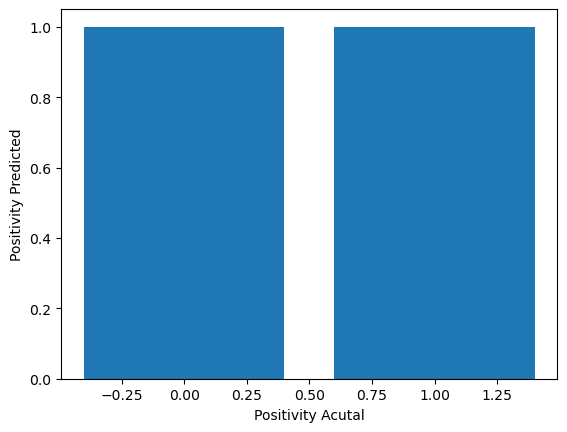

In [214]:
# Let's plot the predictions against the actual result. Use scatter()
# appears that there is an exponential curve to the relationship
_ = plt.bar(y_test, y_pred)
_ = plt.ylabel('Positivity Predicted')
_ = plt.xlabel('Positivity Acutal')
plt.savefig('Positivity for Logistic Regression');

Logitic regression appears to NOT be the answer here.

## Decision Tree Regressor

In [215]:
tree_reg1 = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_reg1.fit(X_train_scaled, y_train)
y_pred_tree1 = tree_reg1.predict(X_test_scaled)

In [216]:
# Evaluate the model: And a halfway decent R-Squared score for a full go; Ok comparison for the test score. 
# Not looking great

print("Training score for DecisionTreeRegressor:", tree_reg1.score(X_train_scaled, y_train))
print("Testing score for DecisionTreeRegressor:", tree_reg1.score(X_test_scaled, y_test))

Training score for DecisionTreeRegressor: 0.2464543438919864
Testing score for DecisionTreeRegressor: -0.022207626807351666


In [217]:
###mean_squared_error, r2_score, mean_absolute_error. TREE WITH DEPTH 2
print('The Root Mean Squared Error Decision Tree Regression Depth 2:', round(np.sqrt(mean_squared_error(y_test,y_pred_tree1)), 2))
print('The Mean Absolute Error Decision Tree Regression Depth 2:', round(mean_absolute_error(y_test,y_pred_tree1), 2))
print('Coefficient of determination Decision Tree Regression Depth 2:', round(r2_score(y_test,y_pred_tree1), 2))

The Root Mean Squared Error Decision Tree Regression Depth 2: 0.51
The Mean Absolute Error Decision Tree Regression Depth 2: 0.45
Coefficient of determination Decision Tree Regression Depth 2: -0.02


In [218]:
# Evaluate the model: And a halfway decent R-Squared score for a full go; Ok comparison for the test score. 
# Not overfit or underfit
print("Training R-sqaured for Decision Tree Regression Depth 6:", tree_reg1.score(X_train_scaled, y_train))
print("Testing R-squared for Decision Tree Regression Depth 6:", tree_reg1.score(X_test_scaled, y_test))

Training R-sqaured for Decision Tree Regression Depth 6: 0.2464543438919864
Testing R-squared for Decision Tree Regression Depth 6: -0.022207626807351666


In [219]:
tree_reg2 = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_reg2.fit(X_train_scaled, y_train)
y_pred_tree2 = tree_reg2.predict(X_test_scaled)

In [220]:
###mean_squared_error, r2_score, mean_absolute_error
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_tree2)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_tree2), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_tree2), 2))

The Root Mean Squared Error: 0.51
The Mean Absolute Error: 0.45
Coefficient of determination: -0.02


In [221]:
features = X_train
importances = list(tree_reg2.feature_importances_)
imp=sorted(importances, reverse=False)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(tab)

                    Features  Importance scores
0               Tweet_Length           0.004937
1              Mention_Count           0.007285
2                 Count_ADJs           0.036127
3                Count_NOUNS           0.037442
4                Count_VERBS           0.055727
5                 vocab_size           0.068668
6                  diversity           0.074507
7    UserName_DiamondPetFood           0.102122
8            UserName_Purina           0.111499
9       UserName_bluebuffalo           0.150004
10  UserName_wellnesspetfood           0.351684


There is simply not a lot of predictive power given the features present. Part of the issue might be the nature of the sentiment casting, since it is the words themselves that determine the sentiment (so word embedding here would be redundant).
Adding vocab size and diversity of words did NOT help any of these scores.

## Linear SVC

In [222]:
lsvc = LinearSVC(verbose=0, max_iter=10000)
lsvc

LinearSVC(max_iter=10000)

In [223]:
lsvc.fit(X_train_scaled, y_train)

LinearSVC(max_iter=10000)

In [224]:
print("Training score for LinearSVC:", lsvc.score(X_train_scaled, y_train))
print("Testing score for LinearSVC:", lsvc.score(X_test_scaled, y_test))
# Again, vocab size and diversity did not help

Training score for LinearSVC: 0.5906642728904847
Testing score for LinearSVC: 0.5397489539748954


In [225]:
cv_scores = cross_val_score(lsvc, X_test_scaled, y_test, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.56


In [226]:
y_pred = lsvc.predict(X_test_scaled)


In [227]:

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[59 63]
 [47 70]]


In [229]:
###mean_squared_error, r2_score, mean_absolute_error
print('The Root Mean Squared Error with LinearSVC Regression:', round(np.sqrt(mean_squared_error(y_test,y_pred)), 2))
print('The Mean Absolute Error with LinearSVC Regression:', round(mean_absolute_error(y_test,y_pred), 2))
print('Coefficient of determination with LinearSVC Regression:', round(r2_score(y_test,y_pred), 2))
## So the errors aren't bad but the R-squared is trash for LinearSVC

The Root Mean Squared Error with LinearSVC Regression: 0.68
The Mean Absolute Error with LinearSVC Regression: 0.46
Coefficient of determination with LinearSVC Regression: -0.84


In [230]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.56      0.48      0.52       122
           1       0.53      0.60      0.56       117

    accuracy                           0.54       239
   macro avg       0.54      0.54      0.54       239
weighted avg       0.54      0.54      0.54       239



Before we throw another model at this effort, let's take a look at decision space

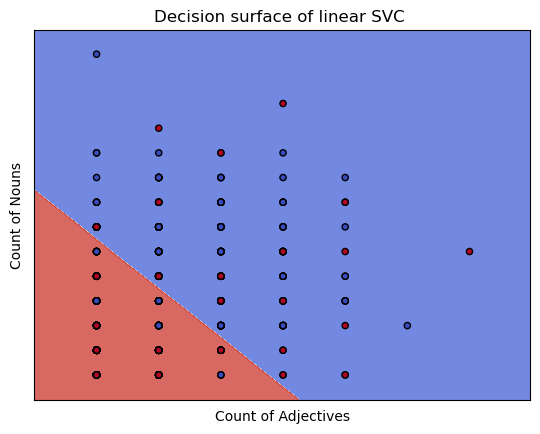

In [231]:
X = df[['Count_ADJs','Count_NOUNS']].to_numpy()  # we only take the first two features.
y = df.sentiment_cut

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = SVC(kernel='linear')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Count of Nouns')
ax.set_xlabel('Count of Adjectives')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.savefig('Decision surface with Nouns and Adjectives')
plt.show()


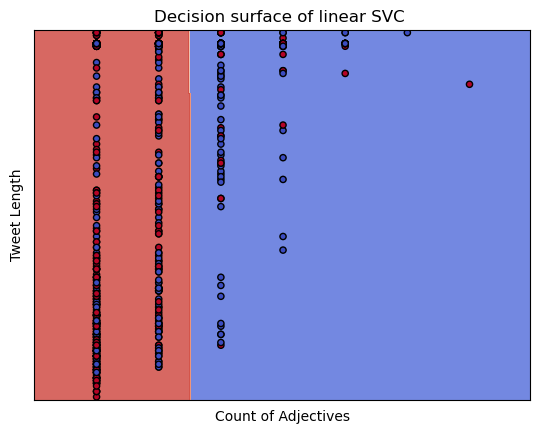

In [59]:
X = df[['Count_ADJs','Tweet_Length']].to_numpy()  # we only take the first two features.
y = df.sentiment_cut

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = SVC(kernel='linear')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Tweet Length')
ax.set_xlabel('Count of Adjectives')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

plt.savefig('Decision surface with Tweet Length and Adjectives')
plt.show()


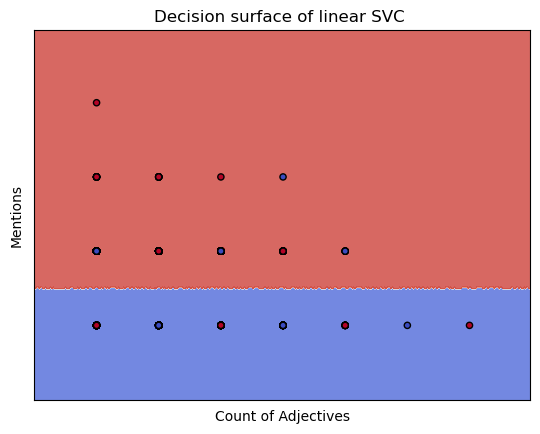

In [61]:
X = df[['Count_ADJs','Mention_Count']].to_numpy()  # we only take the first two features.
y = df.sentiment_cut

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = SVC(kernel='linear')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Mentions')
ax.set_xlabel('Count of Adjectives')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

plt.savefig('Decision surface with Mentions and Adjectives')
plt.show()


KNeighborsClassifier is the next attempt; The addition of the entity counts has not helped any of the models

In [232]:
>>> neigh = KNeighborsClassifier(n_neighbors=3)
>>> neigh.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [233]:
print("Training score for LinearSVC:", neigh.score(X_train_scaled, y_train))
print("Testing score for LinearSVC:", neigh.score(X_test_scaled, y_test))

Training score for LinearSVC: 0.7791741472172352
Testing score for LinearSVC: 0.6234309623430963


In [234]:
y_pred = neigh.predict(X_test_scaled)

In [235]:
###mean_squared_error, r2_score, mean_absolute_error
print('The Root Mean Squared Error with LinearSVC Regression:', round(np.sqrt(mean_squared_error(y_test,y_pred)), 2))
print('The Mean Absolute Error with LinearSVC Regression:', round(mean_absolute_error(y_test,y_pred), 2))
print('Coefficient of determination with LinearSVC Regression:', round(r2_score(y_test,y_pred), 2))
## So the errors aren't bad but the R-squared is trash for LinearSVC

The Root Mean Squared Error with LinearSVC Regression: 0.61
The Mean Absolute Error with LinearSVC Regression: 0.38
Coefficient of determination with LinearSVC Regression: -0.51


In [236]:


cm = confusion_matrix(y_test, y_pred)
print(cm)

[[73 49]
 [41 76]]


In [237]:
cr = classification_report(y_test, y_pred)
print(cr)
#precision and recall are closer and better match
# But LinearSVC() is still a better F1 score for a positive prediction

              precision    recall  f1-score   support

           0       0.64      0.60      0.62       122
           1       0.61      0.65      0.63       117

    accuracy                           0.62       239
   macro avg       0.62      0.62      0.62       239
weighted avg       0.62      0.62      0.62       239



## Gradient Boosted Trees

In [238]:
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train_scaled, y_train)
# make predictions
preds = bst.predict(X_test_scaled)

In [239]:
cm = confusion_matrix(y_test, preds)
print(cm)
# is there hope?

[[70 52]
 [60 57]]


In [240]:
# Evaluate the model: And a halfway decent R-Squared score for a full go; Ok comparison for the test score. 
# Not looking great

print("Training score for XGBClassifier:", bst.score(X_train_scaled, y_train))
print("Testing score for XGBClassifier:", bst.score(X_test_scaled, y_test))
# So only slightly better than KNN; Again, worse with vocab size and diversity

Training score for XGBClassifier: 0.6319569120287253
Testing score for XGBClassifier: 0.5313807531380753


In [241]:
###mean_squared_error, r2_score, mean_absolute_error. TREE WITH DEPTH 2
print('The Root Mean Squared Error XGBClassifier:', round(np.sqrt(mean_squared_error(y_test,preds)), 2))
print('The Mean Absolute Error XGBClassifier:', round(mean_absolute_error(y_test,preds), 2))
print('Coefficient of determination XGBClassifier:', round(r2_score(y_test,preds), 2))

The Root Mean Squared Error XGBClassifier: 0.68
The Mean Absolute Error XGBClassifier: 0.47
Coefficient of determination XGBClassifier: -0.88


In [242]:
cr = classification_report(y_test, preds)
print(cr)
#precision and recall are okish
# But LinearSVC() is still a better F1 score for a positive prediction

              precision    recall  f1-score   support

           0       0.54      0.57      0.56       122
           1       0.52      0.49      0.50       117

    accuracy                           0.53       239
   macro avg       0.53      0.53      0.53       239
weighted avg       0.53      0.53      0.53       239



In [243]:
## Try with trees
# load data in do training
dtrain = xgb.DMatrix(X_train_scaled, y_train)
dtest = xgb.DMatrix(X_test_scaled, y_test)
param = {"max_depth": 2, "eta": 1, "objective": "binary:logistic"}
watchlist = [(dtest, "eval"), (dtrain, "train")]
num_round = 2
bst = xgb.train(param, dtrain, num_boost_round=num_round, evals=watchlist)

# run prediction
preds = bst.predict(dtest)
labels = dtest.get_label()
print(
    "error=%f"
    % (
        sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i])
        / float(len(preds))
    )
)
#Not much improvement here

[0]	eval-logloss:0.69569	train-logloss:0.66339
[1]	eval-logloss:0.69126	train-logloss:0.64131
error=0.468619


In [244]:
###mean_squared_error, r2_score, mean_absolute_error. TREE WITH DEPTH 2
print('The Root Mean Squared Error XGBTrain:', round(np.sqrt(mean_squared_error(y_test,preds)), 2))
print('The Mean Absolute Error XGBTrain:', round(mean_absolute_error(y_test,preds), 2))
print('Coefficient of determination XGBTrain:', round(r2_score(y_test,preds), 2))

The Root Mean Squared Error XGBTrain: 0.5
The Mean Absolute Error XGBTrain: 0.48
Coefficient of determination XGBTrain: 0.0
